# Hand Sign Classification with TensorFlow CNN

In this project I make a Convolutional Neural Network (CNN) with TensorFlow for classifying images of hand signs representing the numbers from 0 to 5. 

<img src="https://thoughtcatalog.files.wordpress.com/2018/03/stop.jpg" style="width:320;height:220px">

This notebook comes from a project of the [Coursera Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning) - highly recommended.

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline

Check TensorFlow version.

In [2]:
tf.VERSION

'1.2.1'

## 1 - Load and check data

Let's load the SIGNS dataset for building our model.

In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

We can check an example of a labeled image.

y = 4


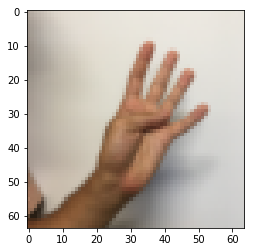

In [4]:
index = 5
plt.imshow(X_train_orig[index])
print('y = ' + str(np.squeeze(Y_train_orig[:, index])))

Let's examine the shape of the data.

In [5]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


## 2 - Define model

### 2.1 - Create placeholders

Create TensorFlow placeholders for input data.

In [6]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """
    
    X = tf.placeholder(tf.float32, shape=[None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, shape=[None, n_y])
    
    return X, Y

In [7]:
X, Y = create_placeholders(64, 64, 3, 6)

print("X = " + str(X))
print("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


### 2.2 - Initialize parameters

Initialize filters $W1$ and $W2$

In [8]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    W1 = tf.get_variable('W1', [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable('W2', [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer())
    
    parameters = {'W1': W1,
                  'W2': W2}
    
    return parameters

In [9]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

W1 = [ 0.04193453  0.1125602  -0.00416544  0.01648183 -0.11247669 -0.11045863
  0.03075659  0.17585738]
W2 = [ 0.18300974 -0.07424903 -0.04377335 -0.00444049  0.03418791  0.00775647
 -0.22232968  0.0962348   0.03386873 -0.07308477  0.09977323  0.05213481
  0.21303004 -0.18214828  0.03708482 -0.05653161]


### 2.3 - Forward propagation

Define the forward propagation function below.

In [10]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve parameters from dictionary
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL
    P1 = tf.nn.max_pool(A1, ksize=[1,8,8,1], strides=[1,8,8,1], padding='SAME')
    # CONV2D
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FC
    Z3 = tf.contrib.layers.fully_connected(P2, num_outputs=6, activation_fn=None)
    
    return Z3

### 2.4 - Compute cost

In [11]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    
    return cost

## 3 - Train and test model

Put together the helper functions to build the model.

In [12]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009,
          num_epochs=100, minibatch_size=64, print_cost=True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    # To rerun model without overwriting tf variables
    ops.reset_default_graph()
    
    # Get shapes
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    
    # Keep track of cost
    costs = []
    
    # Create placeholders
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation
    Z3 = forward_propagation(X, parameters)
    
    # Cost function
    cost = compute_cost(Z3, Y)
    
    # Backpropagation. Use Adam optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize global variables
    init = tf.global_variables_initializer()
    
    # Numpy seed
    seed = 10
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run initialization
        sess.run(init)
        
        # Perform training loop 
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches: 
                (minibatch_X, minibatch_Y) = minibatch
                # Run graph on minibatch
                # Run session to execute optimizer and cost
                _, temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
            
            # Print cost every epoch 
            if print_cost == True and epoch % 5 == 0:
                print(f'Cost after epoch {epoch}: {minibatch_cost}')
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
            
        # Plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.9203676730394363
Cost after epoch 5: 1.8279266953468323
Cost after epoch 10: 1.395648144185543
Cost after epoch 15: 1.1136549822986126
Cost after epoch 20: 0.9095140509307384
Cost after epoch 25: 0.7967573627829552
Cost after epoch 30: 0.6967321261763573
Cost after epoch 35: 0.675619326531887
Cost after epoch 40: 0.6021485179662704
Cost after epoch 45: 0.5774904172867537
Cost after epoch 50: 0.5388034731149673
Cost after epoch 55: 0.5762269347906113
Cost after epoch 60: 0.5113526731729507
Cost after epoch 65: 0.47834437899291515
Cost after epoch 70: 0.44744047336280346
Cost after epoch 75: 0.42846121825277805
Cost after epoch 80: 0.4413440879434347
Cost after epoch 85: 0.464005921036005
Cost after epoch 90: 0.4034307701513171
Cost after epoch 95: 0.40454964991658926


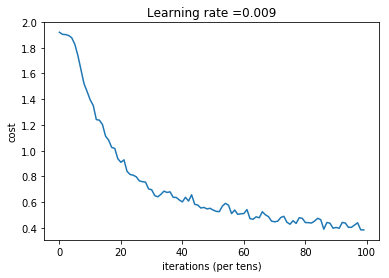

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.866667
Test Accuracy: 0.75


In [13]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

The model recognizes SIGN language with almost 80% accuracy on the test set. The accuracy can be improved by further tuning the hyperparameters or using regularization.